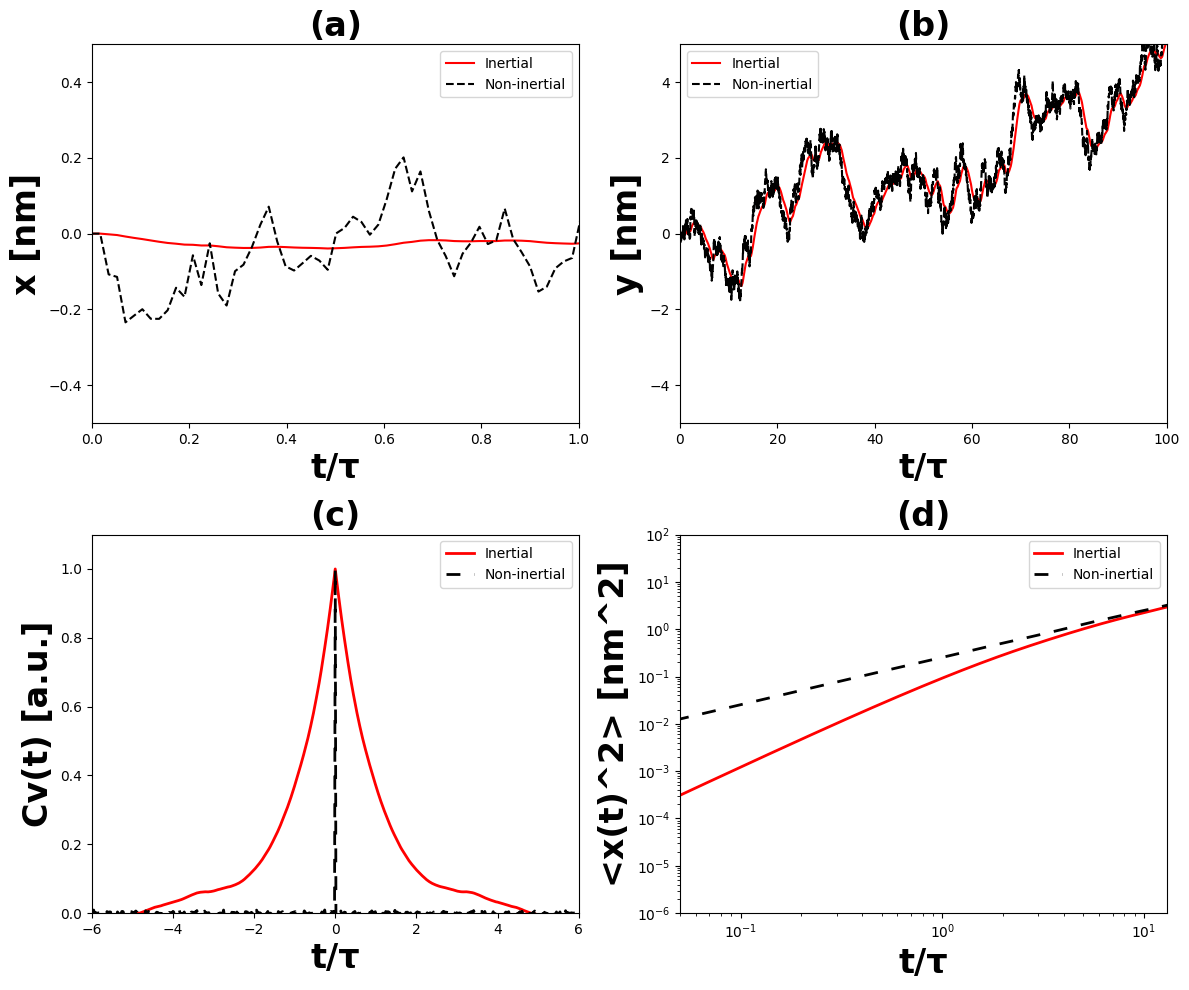

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa import stattools as ac

def inertial(N, Dt, x1, x2, R, T, eta, d):
    kB = 1.38e-23  # Boltzmann constant [J/K]
    gamma = 6 * np.pi * R * eta  
    m = 4 / 3 * np.pi * R**3 * d  
    D = kB * T / gamma
    tau = m / gamma  

    np.random.seed(55)

    x = np.zeros(N)
    y = np.zeros(N)
    x[0], x[1] = x1, x2  #
    for i in range(2, N):
        random = np.random.randn()
        term1 = (2 + Dt / tau) / (1 + Dt / tau) * x[i - 1]
        term2 = -1 / (1 + Dt / tau) * x[i - 2]
        term3 = np.sqrt(2 * kB * T * gamma) / (m + Dt * gamma) * random
        x[i] = term1 + term2 + term3
        y[i] = y[i - 1] + np.sqrt(2 * D * Dt) * random
    
    x=x/1000000000000
    t = np.arange(0, N * Dt, Dt)
    return x, t, tau , y

def acf2(x, Dt):
    v = np.diff(x) / Dt
    v = v - np.mean(v)   
    acorr = correlate(v, v, mode='full')
    acorr /= np.max(acorr)  # Normalize the peak to 1
    max_lag = len(v) - 1
    lags = np.arange(-max_lag, max_lag + 1)
    s = Dt * lags
    return acorr,s

def MSD(x, Dt, fraction=1.0):
    length = len(x)
    max_range = int(length * fraction)
    msd = np.zeros(max_range)

    for n in range(max_range):
        squared_diff = (x[n:] - x[:length - n]) ** 2
        msd[n] = np.mean(squared_diff)

    s = Dt * np.arange(len(msd))
    return msd, s


N = 100000  # Number of steps
Dt = 1e-8 # Time step in seconds
x1, x2 = 0, 0  # Initial conditions
R = 1e-6 # Radius of the particle in meters
T = 300  # Temperature in Kelvin
eta = 0.001  # Viscosity in Ns/m^2
d = 2600 # Density in kg/m^3
y1 = 0

# Generate random walk and calculate tau
x, t, tau, y = inertial(N, Dt, x1, x2, R, T, eta, d)

# Calculate the autocorrelation functions for inertial and non-inertial
acf_i, s_i = acf2(x, Dt)
acf_ni, s_ni = acf2(y, Dt)

# Non-dimensionalize the time scale
s_i_non_dim = s_i / tau
s_ni_non_dim = s_ni / tau

# Generate MSD data for both inertial and non-inertial cases
msd_i, s_i_msd = MSD(x, Dt)
msd_ni, s_ni_msd = MSD(y, Dt)

# Convert the time scale to t/tau
s_i_non_dim_msd = s_i_msd / tau
s_ni_non_dim_msd = s_ni_msd / tau





fig, axs = plt.subplots(2, 2, figsize=(12, 10))  
# First Graph
axs[0, 0].plot(t/tau, x*10**(9), 'r-', label='Inertial')
axs[0, 0].plot(t/tau, y*10**(9), 'k--', label='Non-inertial')
axs[0, 0].set_xlim(0, 1)
axs[0, 0].set_ylim(-0.5*1, 0.5*1)
axs[0, 0].legend()
axs[0, 0].set_title('(a)', fontweight='bold', fontsize = 24)
axs[0, 0].set_ylabel('x [nm]', fontweight='bold', fontsize = 24)
axs[0, 0].set_xlabel('t/τ', fontweight='bold', fontsize = 24)

# Second Graph
axs[0, 1].plot(t/tau, x*10**(9), 'r-', label='Inertial')
axs[0, 1].plot(t/tau, y*10**(9), 'k--', label='Non-inertial')
axs[0, 1].set_xlim(0, 100)
axs[0, 1].set_ylim(-5*1, 5*1)
axs[0, 1].legend()
axs[0, 1].set_title('(b)', fontweight='bold', fontsize = 24)
axs[0, 1].set_ylabel('y [nm]', fontweight='bold', fontsize = 24)
axs[0, 1].set_xlabel('t/τ', fontweight='bold', fontsize = 24)

# Third Graph
axs[1, 0].plot(s_i_non_dim, acf_i, "r-", linewidth=2, label='Inertial')
axs[1, 0].plot(s_ni_non_dim, acf_ni, 'k--', linewidth=2, label='Non-inertial', dashes=(5, 5))
axs[1, 0].set_xlabel('t/τ', fontweight='bold', fontsize = 24)
axs[1, 0].set_ylabel('Cv(t) [a.u.]', fontweight='bold', fontsize = 24)
axs[1, 0].set_xlim(-6, 6)
axs[1, 0].set_ylim(0, 1.1)
axs[1, 0].legend()
axs[1, 0].set_title('(c)',fontweight='bold', fontsize = 24)

# Fourth Graph
axs[1, 1].loglog(s_i_non_dim_msd, msd_i * 10**(18), "r-", linewidth=2, label='Inertial')
axs[1, 1].loglog(s_ni_non_dim_msd, msd_ni* 10**(18), 'k--', linewidth=2, label='Non-inertial', dashes=(5, 5))
axs[1, 1].set_xlabel('t/τ', fontweight='bold', fontsize = 24)
axs[1, 1].set_ylabel('<x(t)^2> [nm^2]', fontweight='bold', fontsize = 24)
axs[1, 1].set_xlim(0.05, 13)
axs[1, 1].set_ylim(10**(-24+18), 10**(-16+18))
axs[1, 1].legend()
axs[1, 1].set_title('(d)', fontweight='bold', fontsize = 24)

plt.tight_layout()  
plt.show()



